# Displaying the header contents of the column density FITS file

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

img_file = get_pkg_data_filename('herschel_cdens.fits')
a = fits.open(img_file)

display(a[0].header)


SIMPLE  =                    T / Written by IDL:  Fri Jul 13 16:58:54 2018      
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1440 / length of data axis 1                          
NAXIS2  =                 1440 / length of data axis 2                          
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = '10^20 cm^-2'        / Image units                                    
CTYPE1  = 'GLON-CAR'           / name of the coordinate axis                    
CTYPE2  = 'GLAT-CAR'           / name of the coordinate axis                    
CRPIX1  =        670.886047000 / coordinate system reference pixel              
CRPIX2  =        803.602600000 / coordinate system reference pixel              
CRVAL1  =        189.3070680

# Displaying the column density FITS file as a greyscale image plot

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(1440, 1440)


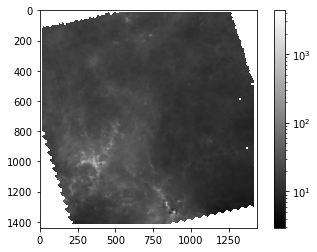

In [13]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

img_data = fits.getdata(img_file)

print(img_data)

print(img_data.shape)
plt.imshow(img_data, cmap='gray', norm = LogNorm())
plt.colorbar()
plt.show()


# Forming a PANDAS dataframe from the provided data and extracting the RA and DEC coordinates into separate lists

In [23]:
from IPython.display import display 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mass = pd.read_csv("2MASS_data.cat", delim_whitespace = True )

err_rem = mass[(mass.Je < 0.1) & (mass.He < 0.1) & (mass.Ke < 0.1)]

err_rem.to_csv('err_rem.csv')

display(err_rem)

ra = err_rem['RAJ2000'].tolist()
dec = err_rem['DECJ2000'].tolist()


,#ID,RAJ2000,DECJ2000,xpix,ypix,J,Je,H,He,K,Ke,f1,f2,f3
1,CAHA_06080950_204113,92.039583,20.687047,3972.1,2347.5,12.193,0.022,11.753,0.020,11.473,0.006,0,0,2
2,CAHA_06081057_204039,92.044042,20.677717,3905.1,2198.4,17.133,0.008,16.053,0.013,15.409,0.010,0,0,2
3,CAHA_06080960_204016,92.040000,20.671111,3965.6,2092.5,15.417,0.005,14.496,0.012,13.991,0.007,0,0,2
4,CAHA_06080913_203932,92.038042,20.659028,3994.0,1899.0,17.283,0.006,16.108,0.005,15.525,0.010,0,0,2
5,CAHA_06080922_203748,92.038417,20.630122,3986.9,1436.4,16.777,0.004,15.848,0.009,15.387,0.006,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46341,CAHA_06094979_203046,92.457458,20.512822,1176.5,2470.4,21.038,0.072,19.980,0.064,18.669,0.055,0,0,2
46347,CAHA_06093632_203053,92.401333,20.514753,2017.7,2498.2,20.955,0.079,19.088,0.044,18.505,0.052,0,0,2
46422,CAHA_06094726_203141,92.446917,20.528136,1335.2,2714.9,20.805,0.084,19.380,0.072,18.558,0.076,0,0,2
46444,CAHA_06094119_203159,92.421625,20.533072,1714.3,2792.5,20.792,0.067,19.280,0.067,18.522,0.055,0,0,2


# Converting the RA and DEC coordinates into GAL coordinates and storing them in a 2D array.

As the coordinate system used in the FITS file is the GAL coordinate systel, and this way it'll be easy to obtain the column density values for the corresponding coordinates

In [48]:
from astropy import wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np

n = len(err_rem)

gal_crd = []

for i in range(n):
    
    c = SkyCoord(ra=ra[i]*u.degree, dec=dec[i]*u.degree, frame='icrs')
    d = c.galactic
    gal_crd.append(d)

sky_coords = []

for i in range(len(gal_crd)):
    sky_coords.append([gal_crd[i].l.degree,gal_crd[i].b.degree])
    
#print(sky_coords)

np.save("gal_coord.npy", sky_coords)

# Obtaining only those values of column density and visual extinction for which we have the coordinates in our provided catalog.

In the previous cell, I've already converted RA, DEC coordinates into GAL coordinates. Here, first I converted the GAL coordinates that I had obtained for our catalog (previous cell) into its corresponding FITS pixel values using wcs from the Astropy library and then obtained the column density for only those coordinates from the FITS file. Then I multiplied every value of column density by a factor of (0.1) to obtain the value of the visual extinction, and stored these lists as columns in the dataframe. Visual extinction is denoted by $A_v$

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy import wcs

gal_crd = np.load("gal_coord.npy")

err_rem = pd.read_csv("err_rem.csv")
del err_rem["Unnamed: 0"]


img_file = get_pkg_data_filename('herschel_cdens.fits')
img_data = fits.getdata(img_file)

w = wcs.WCS(img_file)

col_data = []
x_crd = []
y_crd = []

n = len(gal_crd)

for i in range(n):
        
    px, py = w.wcs_world2pix(gal_crd[i][0], gal_crd[i][1], 1)
    px = int(px)
    py = int(py)
    col_data.append(img_data[px][py])

#print(len(col_data))

ext_map = [element * 0.1 for element in col_data]

#print(ext_map)

fin_dat = err_rem.copy()
fin_dat['col_den'] = col_data
fin_dat['A_v'] = ext_map

display(fin_dat)

fin_dat.to_csv('fin_dat.csv')

,#ID,RAJ2000,DECJ2000,xpix,ypix,J,Je,H,He,K,Ke,f1,f2,f3,col_den,A_v
0,CAHA_06080950_204113,92.039583,20.687047,3972.1,2347.5,12.193,0.022,11.753,0.020,11.473,0.006,0,0,2,15.183496,1.518350
1,CAHA_06081057_204039,92.044042,20.677717,3905.1,2198.4,17.133,0.008,16.053,0.013,15.409,0.010,0,0,2,15.000307,1.500031
2,CAHA_06080960_204016,92.040000,20.671111,3965.6,2092.5,15.417,0.005,14.496,0.012,13.991,0.007,0,0,2,15.356034,1.535603
3,CAHA_06080913_203932,92.038042,20.659028,3994.0,1899.0,17.283,0.006,16.108,0.005,15.525,0.010,0,0,2,16.613628,1.661363
4,CAHA_06080922_203748,92.038417,20.630122,3986.9,1436.4,16.777,0.004,15.848,0.009,15.387,0.006,0,0,2,15.642069,1.564207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19700,CAHA_06094979_203046,92.457458,20.512822,1176.5,2470.4,21.038,0.072,19.980,0.064,18.669,0.055,0,0,2,16.360649,1.636065
19701,CAHA_06093632_203053,92.401333,20.514753,2017.7,2498.2,20.955,0.079,19.088,0.044,18.505,0.052,0,0,2,13.838902,1.383890
19702,CAHA_06094726_203141,92.446917,20.528136,1335.2,2714.9,20.805,0.084,19.380,0.072,18.558,0.076,0,0,2,17.138323,1.713832
19703,CAHA_06094119_203159,92.421625,20.533072,1714.3,2792.5,20.792,0.067,19.280,0.067,18.522,0.055,0,0,2,14.959432,1.495943


# Obtaining the extinction values for J, H, K, [3.6] and [4.5]

For this part, I needed the values of IRAC channels [3.6] and [4.5] that we obtained in phase 1 corresponding with the coordinates that I obtained till now. So to obtain the common list of coordinates I used the match function in TOPCAT selecting the best match (with some error) from the 2 tables (the one obtained in the previous cell, and the one obtained after eliminating all the contaminants in phase 1). The new table had 885 rows. I then simplified the table by eliminating columns that were not needed for further analysis for simplicity, and stored the table in a new dataframe (phase2).

From reference paper (https://arxiv.org/pdf/2104.05840.pdf) I obtained the constant coefficients for each channel J, H, K, [3.6] and [4.5] and multiplied them with each value of the visual extinction obtained in the previous cell, to obtain the extinction values at those particular wavelengths. I then stored these lists as columns in the dataframe.

(The 4 IRAC channels are denoted by ch1, ch3, ch3 and ch4 respectively, in the code, and there error/uncertainities are denoted by ch1_err, ch2_err, ch3_err and ch4_err respectively.)

(The extinction values for J, H and K channels are denoted by $A_J$, $A_H$ and $A_K$ respectively. The extinction values for the 4 IRAC channels are denoted by $A_1$, $A_2$, $A_3$ and $A_4$ respectively)

In [37]:
import pandas as pd

phase2_mod = pd.read_csv("phase2_init.csv")

del phase2_mod['RA_err']
del phase2_mod['DEC_err']
del phase2_mod['f1']
del phase2_mod['f2']
del phase2_mod['f3']
del phase2_mod['xpix']
del phase2_mod['ypix']
del phase2_mod['#ID']
del phase2_mod['col1_1']
del phase2_mod['GroupID']
del phase2_mod['GroupSize']
del phase2_mod['Separation']

C_j = 0.29
C_h = 0.18
C_k = 0.12
C_1 = 0.07
C_2 = 0.06
C_3 = 0.055
C_4 = 0.056


n = len(phase2_mod)

A_j = []
A_h = []
A_k = []
A_1 = []
A_2 = []
A_3 = []
A_4 = []


A_v = phase2_mod['A_v'].tolist()

for i in range (n):
    A_j.append(C_j * A_v[i])
    A_h.append(C_h * A_v[i])
    A_k.append(C_k * A_v[i])
    A_1.append(C_1 * A_v[i])
    A_2.append(C_2 * A_v[i])
    A_3.append(C_3 * A_v[i])
    A_4.append(C_4 * A_v[i])

phase2_mod['A_j'] = A_j
phase2_mod['A_h'] = A_h
phase2_mod['A_k'] = A_k
phase2_mod['A_1'] = A_1
phase2_mod['A_2'] = A_2
phase2_mod['A_3'] = A_3
phase2_mod['A_4'] = A_4

display(phase2_mod)

phase2_mod.to_csv("phase2_mod.csv")

,RA,DEC,ch1,ch1_err,ch2,ch2_err,ch3,ch3_err,ch4,ch4_err,...,Ke,col_den,A_v,A_j,A_h,A_k,A_1,A_2,A_3,A_4
0,92.499558,20.383838,12.056,0.006,12.133,0.008,12.087,0.023,12.073,0.053,...,0.020,14.073218,1.407322,0.408123,0.253318,0.168879,0.098513,0.084439,0.077403,0.078810
1,92.558238,20.397283,11.833,0.005,11.833,0.005,11.907,0.016,12.279,0.056,...,0.021,14.120111,1.412011,0.409483,0.254162,0.169441,0.098841,0.084721,0.077661,0.079073
2,92.522256,20.399500,13.228,0.009,13.263,0.012,13.102,0.045,12.888,0.101,...,0.023,13.932043,1.393204,0.404029,0.250777,0.167185,0.097524,0.083592,0.076626,0.078019
3,92.557130,20.403548,13.507,0.009,13.511,0.010,13.476,0.049,13.648,0.179,...,0.040,13.934748,1.393475,0.404108,0.250825,0.167217,0.097543,0.083608,0.076641,0.078035
4,92.509704,20.420211,12.531,0.006,12.541,0.009,12.329,0.019,11.837,0.042,...,0.009,14.612769,1.461277,0.423770,0.263030,0.175353,0.102289,0.087677,0.080370,0.081832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,92.051629,20.695656,13.395,0.085,13.032,0.010,12.686,0.028,11.397,0.029,...,0.009,15.340987,1.534099,0.444889,0.276138,0.184092,0.107387,0.092046,0.084375,0.085910
881,92.194144,20.717837,13.031,0.073,13.058,0.007,12.782,0.040,12.043,0.045,...,0.004,11.353093,1.135309,0.329240,0.204356,0.136237,0.079472,0.068119,0.062442,0.063577
882,92.205721,20.732680,12.330,0.036,12.271,0.005,12.238,0.022,12.481,0.056,...,0.008,11.632393,1.163239,0.337339,0.209383,0.139589,0.081427,0.069794,0.063978,0.065141
883,92.297810,20.767584,7.538,0.005,7.677,0.006,10.827,0.078,7.426,0.005,...,0.034,12.003082,1.200308,0.348089,0.216055,0.144037,0.084022,0.072018,0.066017,0.067217


# Finding the values required to constrain the previously obtained data and find the total number of YSOs.


$\sigma_1$ represents the error in measurement of ([3.6] - [4.5]). Therefore, $\sigma_1 = \sigma([3.6] - [4.5])_{meas}$. which is then calculated using RMS error method. Therefore, $\sigma_1 = \sqrt{(\sigma_{[3.6]_{meas}})^2 + (\sigma_{[4.5]_{meas}})^2}$

$\sigma_2$ represents the error in measurement of (K - [4.5]). Therefore, $\sigma_1 = \sigma(K - [3.6]_meas)$. which is then calculated using RMS error method. Therefore, $\sigma_2 = \sqrt{(\sigma_{K_{meas}})^2 + (\sigma_{[3.6]_{meas}})^2}$

Now, need to find the intrinsic (absolute) magnitude of ([3.6] - [4.5]). It's denoted by $([3.6] - [4.5])_0$. Now to obtain that, we know that $E_{[3.6] - [4.5]} = ([3.6] - [4.5])_{meas} - ([3.6] - [4.5])_0$ and we also know that $E_{[3.6] - [4.5]} = A_{[3.6]} - A_{[4.5]}$. From all these variables, we can see that $([3.6] - [4.5])_0 = ([3.6] - [4.5])_{meas} - (A_{[3.6]} - A_{[4.5]})$. We know all these constants in RHS from our previous calculations, so thus we can obtain $([3.6] - [4.5])_0$.

We also need to find the intrinsic (absolute) magnitude of (K - [3.6]). It's denoted by $(K - [3.6])_0$. Now to obtain that, we know that $E_{K - [3.6]} = (K - [3.6])_{meas} - (K - [3.6])_0$ and we also know that $E_{K - [3.6]} = A_{K} - A_{[3.6]}$. From all these variables, we can see that $(K - [3.6])_0 = (K - [3.6])_{meas} - (A_{K} - A_{[3.6]})$. We know all these constants in RHS from our previous calculations, so thus we can obtain $(K - [3.6])_0$.

Storing $([3.6] - [4.5])_0$ and $(K - [3.6])_0$ as X and Y in the dataframe respectively.

In [38]:
from numpy import*
import pandas as pd

phase2 = pd.read_csv("phase2_mod.csv")
del phase2['Unnamed: 0']

n = len(phase2)

sigma1 = []
sigma2 = []

E_12 = []
E_k1 = []

M_12 = []
M_k1 = []


ch1 = phase2['ch1'].tolist()
ch2 = phase2['ch2'].tolist()
k = phase2['K'].tolist()

ch1_err = phase2['ch1_err'].tolist()
ch2_err = phase2['ch2_err'].tolist()
ke = phase2['Ke'].tolist()

for i in range(n):
    sigma1.append(sqrt((ch1_err[i])**2 + (ch2_err[i])**2))
    sigma2.append(sqrt((ch1_err[i])**2 + (ke[i])**2))
    E_12.append(A_1[i] - A_2[i])
    E_k1.append(A_k[i] - A_1[i])
    M_12.append(ch1[i] - ch2[i])
    M_k1.append(k[i] - ch1[i])

phase2['sigma1'] = sigma1
phase2['sigma2'] = sigma2


O_12 = []
O_k1 = []


for j in range(n):
    O_12.append(M_12[j] - E_12[j])
    O_k1.append(M_k1[j] - E_k1[j])




phase2['X'] = O_12
phase2['Y'] = O_k1

display(phase2)
phase2.to_csv('phase2.csv')


,RA,DEC,ch1,ch1_err,ch2,ch2_err,ch3,ch3_err,ch4,ch4_err,...,A_h,A_k,A_1,A_2,A_3,A_4,sigma1,sigma2,X,Y
0,92.499558,20.383838,12.056,0.006,12.133,0.008,12.087,0.023,12.073,0.053,...,0.253318,0.168879,0.098513,0.084439,0.077403,0.078810,0.010000,0.020881,-0.091073,-0.026366
1,92.558238,20.397283,11.833,0.005,11.833,0.005,11.907,0.016,12.279,0.056,...,0.254162,0.169441,0.098841,0.084721,0.077661,0.079073,0.007071,0.021587,-0.014120,-0.019601
2,92.522256,20.399500,13.228,0.009,13.263,0.012,13.102,0.045,12.888,0.101,...,0.250777,0.167185,0.097524,0.083592,0.076626,0.078019,0.015000,0.024698,-0.048932,0.331340
3,92.557130,20.403548,13.507,0.009,13.511,0.010,13.476,0.049,13.648,0.179,...,0.250825,0.167217,0.097543,0.083608,0.076641,0.078035,0.013454,0.041000,-0.017935,0.057326
4,92.509704,20.420211,12.531,0.006,12.541,0.009,12.329,0.019,11.837,0.042,...,0.263030,0.175353,0.102289,0.087677,0.080370,0.081832,0.010817,0.010817,-0.024613,0.348936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,92.051629,20.695656,13.395,0.085,13.032,0.010,12.686,0.028,11.397,0.029,...,0.276138,0.184092,0.107387,0.092046,0.084375,0.085910,0.085586,0.085475,0.347659,0.427295
881,92.194144,20.717837,13.031,0.073,13.058,0.007,12.782,0.040,12.043,0.045,...,0.204356,0.136237,0.079472,0.068119,0.062442,0.063577,0.073335,0.073110,-0.038353,0.579235
882,92.205721,20.732680,12.330,0.036,12.271,0.005,12.238,0.022,12.481,0.056,...,0.209383,0.139589,0.081427,0.069794,0.063978,0.065141,0.036346,0.036878,0.047368,0.013838
883,92.297810,20.767584,7.538,0.005,7.677,0.006,10.827,0.078,7.426,0.005,...,0.216055,0.144037,0.084022,0.072018,0.066017,0.067217,0.007810,0.034366,-0.151003,0.383985


# Applying the conditions for YSO classification

The conditions are:

1. $([3.6] - [4.5])_0 - \sigma_1 > 0.101$

2. $(K - [3.6])_0 - \sigma_2 > 0$

3. $(K - [3.6])_0 - \sigma_2 > -2.85714 \cdot (([3.6] - [4.5])_0 - \sigma_1 - 0.101) + 0.5$

Sources that follow all these conditions are the YSOs. These final sources are saved in a new file.


In [39]:
import pandas as pd

phase2 = pd.read_csv("phase2.csv")
del phase2['Unnamed: 0']

p2_yso = phase2[((phase2.X - phase2.sigma1) > 0.101) & ((phase2.Y - phase2.sigma2) > 0) & ((phase2.Y - phase2.sigma2) > ((-2.85714)*(phase2.X - phase2.sigma1 - 0.101) + 0.5))]

display(p2_yso)


p2_yso.to_csv('p2_yso.csv')

,RA,DEC,ch1,ch1_err,ch2,ch2_err,ch3,ch3_err,ch4,ch4_err,...,A_h,A_k,A_1,A_2,A_3,A_4,sigma1,sigma2,X,Y
8,92.487221,20.429207,14.515,0.018,14.246,0.023,14.180,0.121,13.215,0.138,...,0.256921,0.171281,0.099914,0.085640,0.078504,0.079931,0.029206,0.022804,0.254727,0.497633
23,92.503277,20.463642,13.571,0.011,13.115,0.009,12.441,0.030,11.109,0.027,...,0.227712,0.151808,0.088555,0.075904,0.069579,0.070844,0.014213,0.016279,0.443349,0.691747
31,92.545716,20.489193,11.337,0.004,10.466,0.004,9.866,0.005,8.592,0.007,...,0.238437,0.158958,0.092725,0.079479,0.072856,0.074180,0.005657,0.026306,0.857754,1.676768
53,92.512511,20.610175,12.532,0.012,10.683,0.005,9.770,0.006,8.895,0.007,...,0.277269,0.184846,0.107827,0.092423,0.084721,0.086262,0.013000,0.047539,1.833596,2.132981
56,92.516926,20.605171,14.401,0.016,14.070,0.017,14.151,0.100,13.459,0.136,...,0.291160,0.194107,0.113229,0.097053,0.088966,0.090583,0.023345,0.020000,0.314824,0.533122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,92.146818,20.584849,10.139,0.012,9.195,0.010,8.426,0.005,7.801,0.013,...,0.285294,0.190196,0.110948,0.095098,0.087173,0.088758,0.015620,0.012649,0.928150,2.466752
872,92.147217,20.586235,12.002,0.035,11.120,0.029,10.712,0.021,9.874,0.034,...,0.291810,0.194540,0.113482,0.097270,0.089164,0.090785,0.045453,0.042438,0.865788,0.856942
874,92.147298,20.601146,7.529,0.005,6.982,0.004,6.180,0.006,5.197,0.004,...,0.263985,0.175990,0.102661,0.087995,0.080662,0.082129,0.006403,0.028443,0.532334,1.322671
880,92.051629,20.695656,13.395,0.085,13.032,0.010,12.686,0.028,11.397,0.029,...,0.276138,0.184092,0.107387,0.092046,0.084375,0.085910,0.085586,0.085475,0.347659,0.427295


# Identifying Class I YSOs

The YSOs identified in the previous cell are classified as Class I YSOs or likely protostars have to follow this condition:

$(K - [3.6])_0 - \sigma_2 > -2.85714 \cdot (([3.6] - [4.5])_0 - \sigma_1 - 0.401) + 1.7$

The Class I YSOs are written into a new file.
The YSOs which do not follow this out of the total are considered Class II (next cell)

The Class I YSOs (black) are plotted in a colour colour plot along with the total YSOs (grey) to provide a graphical depiction. The colour colour plot has $([3.6] - [4.5])_0$ on the x axis and $(K - [3.6])_0$ on the y axis.



Total number of Class I YSOs is:  107

Table: 



,RA,DEC,ch1,ch1_err,ch2,ch2_err,ch3,ch3_err,ch4,ch4_err,...,A_h,A_k,A_1,A_2,A_3,A_4,sigma1,sigma2,X,Y
2,92.545716,20.489193,11.337,0.004,10.466,0.004,9.866,0.005,8.592,0.007,...,0.238437,0.158958,0.092725,0.079479,0.072856,0.074180,0.005657,0.026306,0.857754,1.676768
3,92.512511,20.610175,12.532,0.012,10.683,0.005,9.770,0.006,8.895,0.007,...,0.277269,0.184846,0.107827,0.092423,0.084721,0.086262,0.013000,0.047539,1.833596,2.132981
15,92.153993,20.656068,12.130,0.007,11.447,0.006,10.718,0.014,9.506,0.015,...,0.235894,0.157263,0.091736,0.078631,0.072079,0.073389,0.009220,0.083295,0.669895,1.924474
16,92.264661,20.692902,11.557,0.006,10.726,0.005,10.209,0.011,9.532,0.017,...,0.211545,0.141030,0.082267,0.070515,0.064639,0.065814,0.007810,0.009220,0.819248,1.517238
17,92.306519,20.619149,15.254,0.034,13.729,0.017,12.495,0.044,11.309,0.050,...,0.295285,0.196857,0.114833,0.098428,0.090226,0.091866,0.038013,0.102786,1.508595,1.297976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,92.464273,20.476278,11.298,0.022,10.295,0.004,9.487,0.037,8.443,0.006,...,0.234536,0.156358,0.091209,0.078179,0.071664,0.072967,0.022361,0.022804,0.989970,1.526851
277,92.133635,20.523708,12.240,0.042,11.471,0.006,10.926,0.014,10.270,0.022,...,0.309790,0.206526,0.120474,0.103263,0.094658,0.096379,0.042426,0.042426,0.751789,1.135947
278,92.146818,20.584849,10.139,0.012,9.195,0.010,8.426,0.005,7.801,0.013,...,0.285294,0.190196,0.110948,0.095098,0.087173,0.088758,0.015620,0.012649,0.928150,2.466752
279,92.147217,20.586235,12.002,0.035,11.120,0.029,10.712,0.021,9.874,0.034,...,0.291810,0.194540,0.113482,0.097270,0.089164,0.090785,0.045453,0.042438,0.865788,0.856942



Plot:



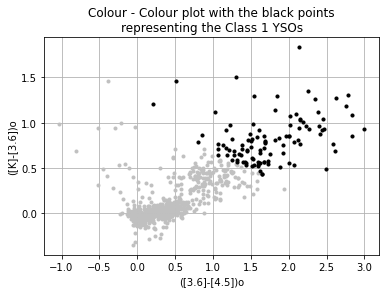

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

phase2 = pd.read_csv("phase2.csv")

p2_yso = pd.read_csv("p2_yso.csv")
del p2_yso['Unnamed: 0']

p2_cls1 = p2_yso[(p2_yso.Y - p2_yso.sigma2) > ((-2.85714)*(p2_yso.X - p2_yso.sigma1 - 0.401)+1.7)]

print('\n\nTotal number of Class I YSOs is: ', len(p2_cls1))
print('\nTable: \n')

display(p2_cls1)

p2_cls1.to_csv('p2_cls1.csv')

#colour colour plot

X1 = phase2['X'].tolist()
Y1 = phase2['Y'].tolist()

X2 = p2_cls1['X'].tolist()
Y2 = p2_cls1['Y'].tolist()


print('\nPlot:\n')
plt.xlabel('([3.6]-[4.5])o')
plt.ylabel('([K]-[3.6])o')
plt.title("Colour - Colour plot with the black points\nrepresenting the Class 1 YSOs")
plt.plot(Y1,X1,color = 'silver', marker = ".", linestyle='None')
plt.plot(Y2,X2,'k.')
plt.grid()
plt.show()

# Identifying Class II YSOs

The YSOs that do not follow the condition mentioned in the previous section are considered as Class II YSOs. SO, to obtain the list of Class II YSOs, I eliminated the Class I YSOs from the total number of YSOs. The list of the Class II YSOs is stored into a new file.

,RA,DEC,ch1,ch1_err,ch2,ch2_err,ch3,ch3_err,ch4,ch4_err,...,A_h,A_k,A_1,A_2,A_3,A_4,sigma1,sigma2,X,Y
0,92.487221,20.429207,14.515,0.018,14.246,0.023,14.180,0.121,13.215,0.138,...,0.256921,0.171281,0.099914,0.085640,0.078504,0.079931,0.029206,0.022804,0.254727,0.497633
1,92.503277,20.463642,13.571,0.011,13.115,0.009,12.441,0.030,11.109,0.027,...,0.227712,0.151808,0.088555,0.075904,0.069579,0.070844,0.014213,0.016279,0.443349,0.691747
4,92.516926,20.605171,14.401,0.016,14.070,0.017,14.151,0.100,13.459,0.136,...,0.291160,0.194107,0.113229,0.097053,0.088966,0.090583,0.023345,0.020000,0.314824,0.533122
5,92.522748,20.701457,14.601,0.013,13.966,0.017,13.753,0.053,13.013,0.099,...,0.245856,0.163904,0.095611,0.081952,0.075123,0.076489,0.021401,0.015264,0.621341,0.475707
6,92.533147,20.729906,13.364,0.010,12.906,0.010,12.574,0.029,12.163,0.051,...,0.205574,0.137049,0.079945,0.068525,0.062814,0.063956,0.014142,0.014142,0.446579,1.513896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,92.196382,20.760692,12.794,0.005,12.428,0.008,12.062,0.017,11.338,0.029,...,0.216324,0.144216,0.084126,0.072108,0.066099,0.067301,0.009434,0.006403,0.353982,1.090910
272,92.045391,20.763084,14.359,0.010,14.055,0.021,13.821,0.046,13.221,0.187,...,0.231344,0.154229,0.089967,0.077115,0.070688,0.071974,0.023259,0.011180,0.291148,0.775738
274,92.366176,20.776036,14.297,0.012,14.030,0.012,13.505,0.048,12.719,0.069,...,0.209087,0.139391,0.081312,0.069696,0.063888,0.065049,0.016971,0.013892,0.255384,0.740920
280,92.147298,20.601146,7.529,0.005,6.982,0.004,6.180,0.006,5.197,0.004,...,0.263985,0.175990,0.102661,0.087995,0.080662,0.082129,0.006403,0.028443,0.532334,1.322671



Plot:



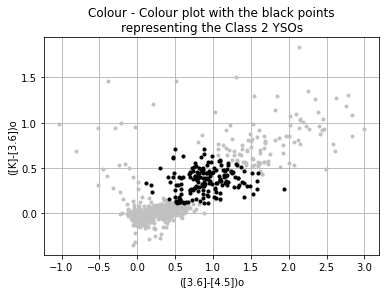

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

phase2 = pd.read_csv("phase2.csv")

p2_yso = pd.read_csv("p2_yso.csv")
del p2_yso['Unnamed: 0']

p2_cls1 = pd.read_csv("p2_cls1.csv")
del p2_cls1['Unnamed: 0']


common = p2_yso.merge(p2_cls1, on=["RA","DEC"])
p2_cls2 = p2_yso[(~p2_yso.RA.isin(common.RA)) & (~p2_yso.DEC.isin(common.DEC))]

p2_cls2.to_csv('p2_cls2.csv')

display(p2_cls2)

#colour colour plot

X1 = phase2['X'].tolist()
Y1 = phase2['Y'].tolist()

X2 = p2_cls2['X'].tolist()
Y2 = p2_cls2['Y'].tolist()


print('\nPlot:\n')
plt.xlabel('([3.6]-[4.5])o')
plt.ylabel('([K]-[3.6])o')
plt.title("Colour - Colour plot with the black points\nrepresenting the Class 2 YSOs")
plt.plot(Y1,X1,color = 'silver', marker = ".", linestyle='None')
plt.plot(Y2,X2,'k.')
plt.grid()
plt.show()

# Plotting both Class I YSOs and Class II YSOs together

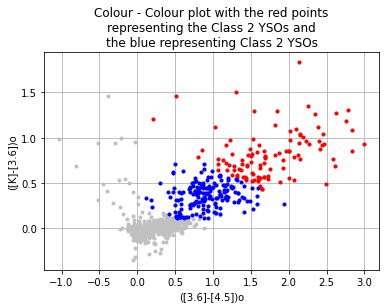

In [46]:
import matplotlib.pyplot as plt
import pandas as pd


phase2 = pd.read_csv("phase2.csv")
p2_cls1 = pd.read_csv("p2_cls1.csv")
p2_cls2 = pd.read_csv("p2_cls2.csv")

X1 = phase2['X'].tolist()
Y1 = phase2['Y'].tolist()

X2 = p2_cls1['X'].tolist()
Y2 = p2_cls1['Y'].tolist()

X3 = p2_cls2['X'].tolist()
Y3 = p2_cls2['Y'].tolist()


plt.xlabel('([3.6]-[4.5])o')
plt.ylabel('([K]-[3.6])o')
plt.title("Colour - Colour plot with the red points\nrepresenting the Class 2 YSOs and\nthe blue representing Class 2 YSOs")
plt.plot(Y1,X1,color = 'silver', marker = ".", linestyle='None')
plt.plot(Y2,X2,'r.')
plt.plot(Y3,X3,'b.')

plt.grid()
plt.show()

# Forming Region Files for Class I and Class II YSOs for Phase 2

In [7]:
import pandas as pd

f = open("p2cls1reg.reg","w")
g = open("p2cls2reg.reg","w")

p2cls1 = pd.read_csv("p2_cls1.csv")
p2cls2 = pd.read_csv("p2_cls2.csv")

ra1 = p2cls1["RA"].tolist()
dec1 = p2cls1["DEC"].tolist()


ra2 = p2cls2["RA"].tolist()
dec2 = p2cls2["DEC"].tolist()


f.write("global color=yellow width=2 fixed=0 select=1 edit=1 move=0 delete=1 highlite=1 include=1 source=1\n")

g.write("global color=blue width=2 fixed=0 select=1 edit=1 move=0 delete=1 highlite=1 include=1 source=1\n")


for i in range(len(p2cls1)):
    str1 = str(ra1[i])
    str2 = str(dec1[i])
    fin = "fk5; point("+str1+","+str2+") #point=circle\n"
    f.write(fin)

    
for j in range(len(p2cls2)):
    str11 = str(ra2[j])
    str22 = str(dec2[j])
    fin1 = "fk5; point("+str11+","+str22+") #point=circle\n"
    g.write(fin1)
    
    
f.close()
g.close()

print("Region files for class I and class II YSOs for phase 2 created")

Region files for class I and class II YSOs for phase 2 created
